![](image.png)

# Background

Many regions around the world still face challenges in providing the access to **clean and safe water** to their populations. **Bandung**, one of the largest city in Indonesia, is influenced by multiple industrial activities and urbanization that can damage the water quality in its environment. Many Bandung’s residents rely on **well water** as a primary source of water (including drinking water), making it essential for the government and related institutions to monitor and improve the quality of water from these sources.

This report aims to address the critical issue of well water quality in Bandung by implementing data analysis techniques, specifically **hierarchical clustering** analysis, to provide valuable insights and recommendations for government agencies and institutions responsible for water resource management and public health.

# Objectives

The primary objectives of this analysis are as follows:

1. **Identify Water Quality Clusters**: Through clustering analysis, I aim to group well water sources in Bandung into clusters with similar water quality profiles. These clusters will provide a clearer understanding of regional trends and variations in water quality.
2. **Promote Public Health and Environmental Awareness**: Additionally, this analysis can be seen as a contribution to the enhancement of public health and the preservation of the environment by promoting public health and environmental awareness, especially in the quality of well water for the residents of Bandung.

# Dataset

***For some privacy reason, I can’t share the dataset source here.***

In [1]:
#| echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The dataset has 160 rows and 11 columns. Let’s take a quick look at the data.

In [2]:
#| label: tbl-1
#| tbl-cap: "Data Snippet"
# Data Preview
data = pd.read_excel(
    "Data Analisis Statistik-2023-kualitas air-raw.xlsx", index_col=0)

# We don't need these '>BM xx' data because we don't have information about what these indicators really mean
# Also, for skill demonstration purpose, I will remove the 'Kode' and 'Jenis Air' columns first.
data = data.drop(['Nomor sampel', 'Kode', 'Jenis Air', '>BM Cd',
                 '>bm Hg', '>BM Mn', '>BM Pb', '>BM Zn', '>BM Fe'], axis=1)
data

,Sampel ID,As,Cd,Co,Cr,Cu,Fe,Hg,Mn,Pb,Zn
No,,,,,,,,,,,
1,MJ-AS-01,0.0062,0.0001,0.0026,0.0069,0.0100,1.6585,0.0001,0.3428,0.0001,0.1079
2,MJ-AS-03,0.0212,0.0006,0.0001,0.0070,0.0077,3.7910,0.0001,0.4119,0.0119,0.0309
3,MJ-AS-04,0.0065,0.0001,0.0001,0.0062,0.0073,0.0820,0.0001,0.2206,0.0186,0.0521
4,MJ-AS-05,0.0162,0.0006,0.0001,0.0084,0.0094,1.4833,0.0001,0.4985,0.0001,0.0886
5,MJ-AS-05B,0.0194,0.0001,0.0001,0.0086,0.0098,2.3356,0.0001,0.1716,0.0196,0.0641
...,...,...,...,...,...,...,...,...,...,...,...
156,SR-ASAM-08,0.0164,0.0001,0.0001,0.0059,0.0024,0.3552,0.0001,0.0012,0.0001,0.0739
157,SR-ASAM-14,0.0196,0.0019,0.0171,0.0053,0.0125,0.1067,0.0001,0.7120,0.0495,0.8312
158,SR-ASAM-20,0.0062,0.0001,0.0085,0.0076,0.0089,0.0684,0.0001,1.1956,0.0235,0.0755


The first column is an ID where its values are formatted as Region Code-Water Type-Sample Number. As we will see later, there are 2 type of water:

- ASAM (drinkable)
- AS (not drinkable)

and 7 different region code:

- MJ (Majalengka)
- BL (Baleendah)
- CP (Ciparay)
- PC (Pacet)
- PL (Pangalengan)
- RC (Rancaekek)
- SR (Soreang)

The rest of the columns are indicators of how much the water is contaminated by the associated substances.

# Pre-analysis

## Extract Code and Water Type

As mentioned earlier, the ID values are formatted as Region Code-Water Type-Sample Number. To make the analysis easier, I will extract the **region code and water type** from the ID value into their own column. 

In [3]:
# split the ID value, then get the first string for the region and second string for the type
data['Region'] = data['Sampel ID'].str.split('-').str[0]
data['Type'] = data['Sampel ID'].str.split('-').str[1]

In [4]:
#| label: tbl-2
#| tbl-cap: "First three rows of modified data"
#| echo: false
data.head(3)

,Sampel ID,As,Cd,Co,Cr,Cu,Fe,Hg,Mn,Pb,Zn,Region,Type
No,,,,,,,,,,,,,
1,MJ-AS-01,0.0062,0.0001,0.0026,0.0069,0.0100,1.6585,0.0001,0.3428,0.0001,0.1079,MJ,AS
2,MJ-AS-03,0.0212,0.0006,0.0001,0.0070,0.0077,3.7910,0.0001,0.4119,0.0119,0.0309,MJ,AS
3,MJ-AS-04,0.0065,0.0001,0.0001,0.0062,0.0073,0.0820,0.0001,0.2206,0.0186,0.0521,MJ,AS


Great. Now let's check if the new columns were extracted correctly.

In [5]:
print('Region unique values:', data['Region'].unique())

print('Type unique values:', data['Type'].unique())

Region unique values: ['MJ' 'BL' 'CP' 'PC' 'PL' 'RC' 'SR']
Type unique values: ['AS' 'ASAM' '08' '11' '12' '13' 'ASAM‐19']


Now we have a problem. The `type` column should only consists of AS or ASAM. As you can see, there's another value present in this data. Let's figure out which rows contain these errors.

In [6]:
#| label: tbl-3
#| tbl-cap: "Rows contain errors"
data[~data['Sampel ID'].str.split('-').str[1].isin(['AS', 'ASAM'])]

,Sampel ID,As,Cd,Co,Cr,Cu,Fe,Hg,Mn,Pb,Zn,Region,Type
No,,,,,,,,,,,,,
52,CP-08-AS,0.0155,0.0010,0.0001,0.0128,0.0113,6.2391,0.0001,0.6119,0.0142,0.1370,CP,08
53,CP-11-ASAM,0.0190,0.0009,0.0001,0.0172,0.0106,0.2971,0.0001,0.0250,0.0151,0.1104,CP,11
54,CP-12-AS,0.0134,0.0001,0.0008,0.0186,0.0119,0.2941,0.0001,0.2472,0.0049,0.1761,CP,12
55,CP-13-AS,0.0133,0.0010,0.0016,0.0296,0.0138,3.1102,0.0001,0.4770,0.0055,0.1123,CP,13
70,CP-ASAM‐19,0.0023,0.0010,0.0001,0.0135,0.0311,0.1585,0.0001,0.0893,0.0001,0.2647,CP,ASAM‐19


Looks like there are only 5 rows that are problematic. Let's just fix them manually.

In [7]:
data.loc[[52, 54, 55], 'Type'] = 'AS'
data.loc[[53, 70], 'Type'] = 'ASAM'

Let's see if those rows already been changed.

In [8]:
#| label: tbl-4
#| tbl-cap: "Modified rows"
data[~data['Sampel ID'].str.split('-').str[1].isin(['AS', 'ASAM'])]

,Sampel ID,As,Cd,Co,Cr,Cu,Fe,Hg,Mn,Pb,Zn,Region,Type
No,,,,,,,,,,,,,
52,CP-08-AS,0.0155,0.0010,0.0001,0.0128,0.0113,6.2391,0.0001,0.6119,0.0142,0.1370,CP,AS
53,CP-11-ASAM,0.0190,0.0009,0.0001,0.0172,0.0106,0.2971,0.0001,0.0250,0.0151,0.1104,CP,ASAM
54,CP-12-AS,0.0134,0.0001,0.0008,0.0186,0.0119,0.2941,0.0001,0.2472,0.0049,0.1761,CP,AS
55,CP-13-AS,0.0133,0.0010,0.0016,0.0296,0.0138,3.1102,0.0001,0.4770,0.0055,0.1123,CP,AS
70,CP-ASAM‐19,0.0023,0.0010,0.0001,0.0135,0.0311,0.1585,0.0001,0.0893,0.0001,0.2647,CP,ASAM


I think everything is fine by now. Next, we will proceed into the visualization part.

# EDA


Before proceeding into the clustering analysis, it is essential to do EDA first in order to gain a deep understanding of the dataset and the patterns it may reveal.

## Univariate EDA

### Number of Well in Each Region

In the dataset, it is important to notice that each region is represented by a relatively similar number of well samples, ranging from 18 samples to 27 samples. This balanced distribution of data across regions ensures that our analysis and clustering results will be relatively robust and unbiased by its geographical location.

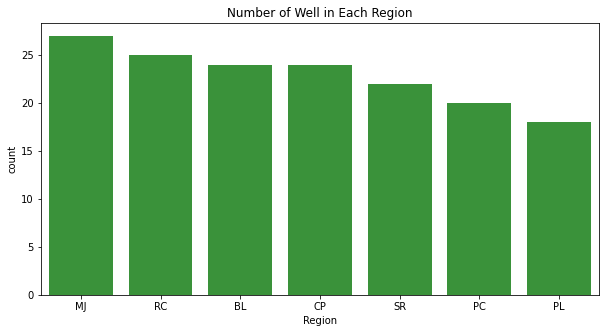

In [9]:
#| label: fig-1
#| fig-cap: "Number of well in each region"
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Region', order=data['Region'].value_counts().index, color="tab:green")
plt.title("Number of Well in Each Region")
plt.show()

### Number of Well from Each Water Type

However, there are higher number of well with undrinkable water (AS) in comparison to well with drinkable water (ASAM). This disproportion emphasizes a significant concern regarding the availability of safe drinking water sources in the regions of Bandung, as a considerably larger proportion of the wells are observed to exhibit water quality issues.

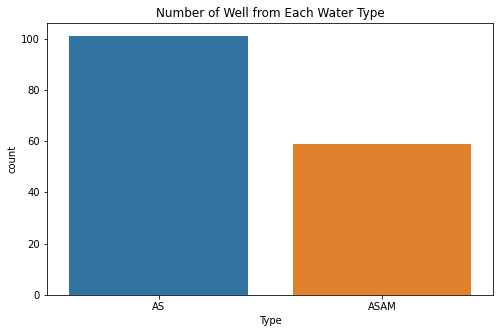

In [10]:
#| label: fig-2
#| fig-cap: "Number of Well from Each Water Type"
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Type')
plt.title("Number of Well from Each Water Type")
plt.show()

### Number of Well in Each Region by Water Type

While several regions like Pacet and Pangalengan already have more drinkable-water wells than undrinkable ones, most of the regions still grapple with a concerning disparity. In these areas, the amount of undrinkable-water wells not only surpasses their drinkable counterparts but does so by a substantial margin.

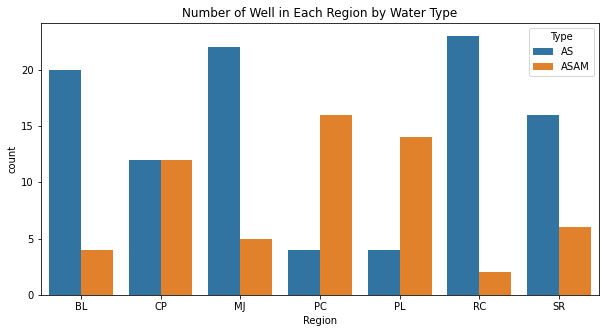

In [11]:
#| label: fig-3
#| fig-cap: "Number of Well in Each Region by Water Type"
plt.figure(figsize=(10, 5))
sns.countplot(x='Region',
              data=data,
              order=['BL', 'CP', 'MJ', 'PC', 'PL', 'RC', 'SR'],
              hue='Type')
plt.title("Number of Well in Each Region by Water Type")
plt.show()

### Mean of Substances Concentration in Each Region

In any region, calculated by the mean of concentration, three substances dominates among another: iron (Fe), manganese (Mn), and zinc (Zn). In most of the regions, wells are heavily contaminated by iron. Some exceptions are Pacet and Pangalengan, where the wells are contaminated dominantly by manganese, and Soreang, where the wells are contaminated by iron and manganese equally.

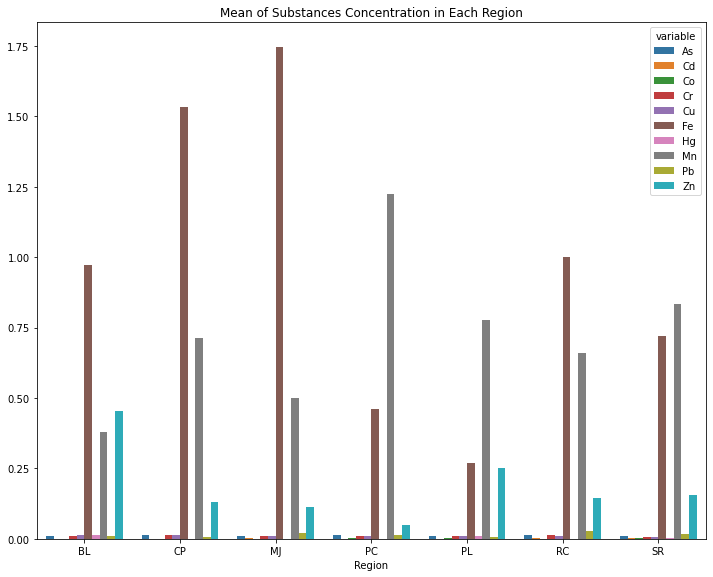

In [12]:
#| label: fig-4
#| fig-cap: "Mean of Substances Concentration in Each Region"
data_gp = data.iloc[:, 1:-1].groupby(['Region']).agg('mean')
res = data_gp.reset_index()
res_wide = res.melt(id_vars="Region")

plt.figure(figsize=(12, 9.5))
sns.barplot(x="Region", y="value", data=res_wide, hue='variable')
plt.title('Mean of Substances Concentration in Each Region')
plt.ylabel('')
plt.show()

### Mean of Substances Concentration in Each Region (AS/ASAM Only)

If we take a look back at @fig-3, Pacet and Pangalengan are the only region that have more drinkable-water water source than the undrinkable one. This may suggest that low level of iron (or high level of manganese) contamination is one of the indicator for a healthy, drinkable water.

However, if we look at the next two plots, where these are similar to @fig-4 but separated by the water type, there are undrinkable water with high level of manganese as well as drinkable water with high level of iron. Therefore, at least for now, neither manganese contamination level nor iron contamination level can be considered as an indicator of undrinkable water.

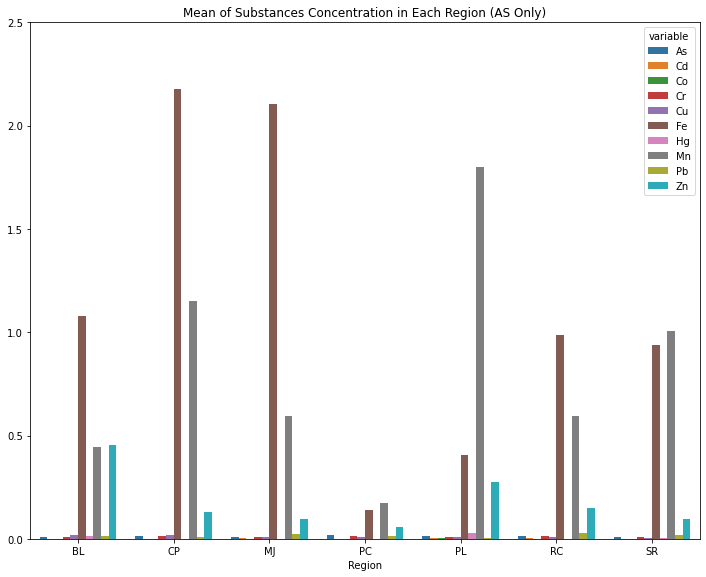

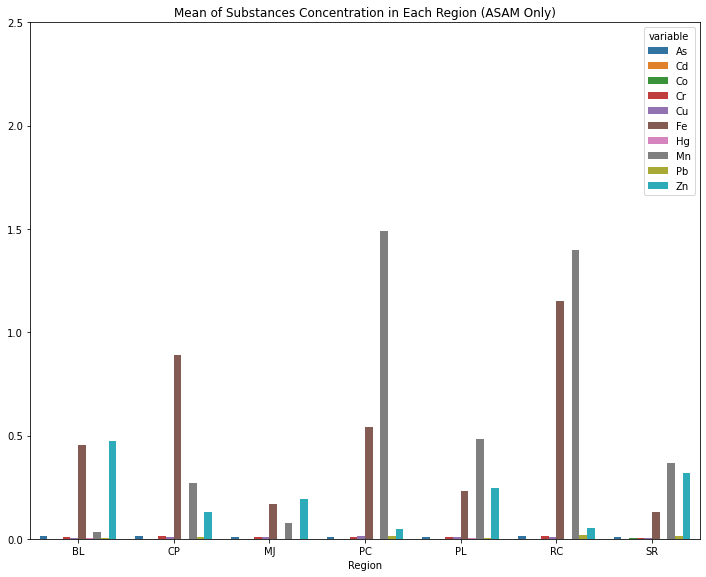

In [13]:
#| label: fig-5
#| fig-cap: "Mean of Substances Concentration in Each Region"
#| fig-subcap: 
#|   - "(AS Only)"
#|   - "(ASAM Only)"
#| layout-ncol: 2
data_gp = data[data['Type'] == 'AS'].iloc[:, 1:-1].groupby(['Region']).agg('mean')
res = data_gp.reset_index()
res_wide=res.melt(id_vars="Region")

plt.figure(figsize=(12,9.5))
sns.barplot(x="Region", y="value",data=res_wide, hue='variable')
plt.title('Mean of Substances Concentration in Each Region (AS Only)')
plt.ylabel('')
plt.ylim(0, 2.5)
plt.show()

data_gp = data[data['Type'] == 'ASAM'].iloc[:, 1:-1].groupby(['Region']).agg('mean')
res = data_gp.reset_index()
res_wide=res.melt(id_vars="Region")

plt.figure(figsize=(12,9.5))
sns.barplot(x="Region", y="value",data=res_wide, hue='variable')
plt.title('Mean of Substances Concentration in Each Region (ASAM Only)')
plt.ylabel('')
plt.ylim(0, 2.5)
plt.show()

## Multivariate EDA

### Substances Concentration Variable

Regarding the variables related to substances concentration, every single one of them has a positive skewed distribution. Because the plot for all 10 substances is too large, as an example, I will only show the distribution of three variable along with the correlation between each two of them.

As for the results, there isn’t any notable result except for the fact that the Cadmium (Cd) and Lead (Pb) are highly correlated. Deeper knowledge about chemistry and water engineering might be needed to gain meaningful insights from this result.

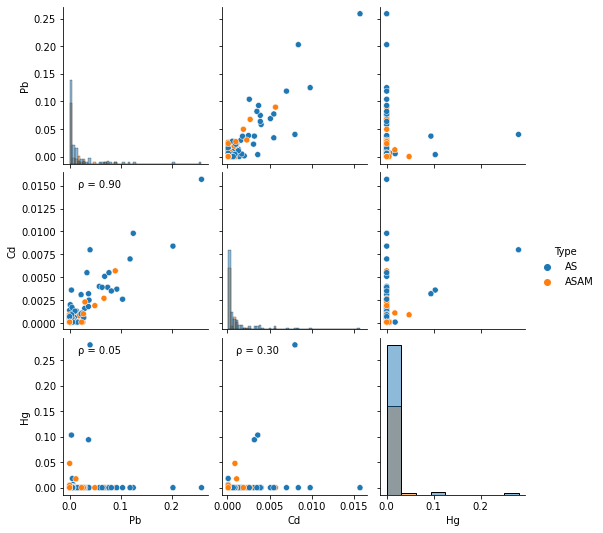

In [12]:
#| label: fig-6
#| fig-cap: "Distribution of 3 (out of 10) substance along with correlation between each two of them"

from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, hue=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(data=data[['Pb', 'Cd', 'Hg', 'Type']], hue='Type', diag_kind='hist')
g.map_lower(corrfunc)
plt.show()

# Clustering


We now turn our attention to the core of our analysis: clustering analysis.

## Methods

In this analysis, I will specifically use **hierarchical clustering** method with four kinds of linkage:

1. **Single linkage**, where the distance of two clusters A and B is defined with the **minimum** distance between a point in A and a point in B.
$$
{\displaystyle \min _{a\in A,\,b\in B}d(a,b)}
$$ {#eq-single-linkage}
2. **Complete linkage**, where the distance of two clusters A and B is defined with the **maximum** distance between a point in A and a point in B. 
$$
{\displaystyle \max _{a\in A,\,b\in B}d(a,b)}
$$ {#complete-linkage}
3. **Average linkage**, where the distance between two clusters A and B is defined as the **average** of the distances between every points in A and every points in B.
$$
{\displaystyle {\frac {1}{|A|\cdot |B|}}\sum _{a\in A}\sum _{b\in B}d(a,b)}
$$ {#average-linkage}
4. **Ward’s linkage**, where at each step, it joins two clusters A and B that minimize the increase in SSE (sum-squared error) defined as below. 
$$
SSE = \sum _{x\in A\cup B}\lVert x-\mu _{A\cup B}\rVert ^{2}-\sum _{x\in A}\lVert x-\mu _{A}\rVert ^{2}-\sum _{x\in B}\lVert x-\mu _{B}\rVert ^{2}
$$ {#ward-linkage}

Note that at each step in single linkage, complete linkage, and average linkage, they join the two clusters with the smallest distance, as measured with the respective distance definition.

In python, you can perform hierarchical analysis by utilizing the functions offered by the [SciPy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) package.

In [13]:
#| code-fold: false
from scipy.cluster.hierarchy import dendrogram, linkage

::: {.callout-tip}
If you are not familiar yet with the concept of hierarchical clustering, I suggest you to read [this article](https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec) and [this wikipedia page](https://en.wikipedia.org/wiki/Hierarchical_clustering).
:::

## Number of Cluster

From previous EDA, we have seen that the data often can be divided into three categories. For example, in @fig-3, we can categorize the data like this

1. region where the number of AS well-water is more than ASAM water,
2. region where the number of ASAM well-water is more than AS, and
3. region where the number of AS well-water and ASAM well-water are equal.

Another example is present in figure 8, where we can categorize the data like this
1. region where the concentration mean of iron is higher than manganese,
2. region where the concentration mean of manganese is higher than iron, and
3. region where the concentration mean of iron and manganese are equal.

Therefore, given the results of what we've explored (that sugggests there is an inherent structure and pattern in the data), I will choose **three** as the number of cluster in this analysis. Of course, these categorization may seems arbitrary (indeed they are). However, as we will see in the clustering result, the selection of three clusters is not a bad decision.

## Aggregation


The clustering process will be based on the substances concentrations value at each region. Because one region contains several wells, we need to aggregate them first. In this analysis I use the mean aggregation. You can see the result as below.

In [14]:
#| label: tbl-5
#| tbl-cap: "Aggregated Data"
data = data.iloc[:, 1:-1]
agg_mean = data.groupby('Region').agg('mean')
agg_mean

,As,Cd,Co,Cr,Cu,Fe,Hg,Mn,Pb,Zn
Region,,,,,,,,,,
BL,0.011117,0.001004,0.001029,0.008858,0.014692,0.973554,0.013504,0.377721,0.009838,0.455558
CP,0.012358,0.000517,0.000938,0.014554,0.013850,1.534404,0.000308,0.711413,0.007667,0.130892
MJ,0.008978,0.001396,0.000778,0.008219,0.008593,1.746515,0.000100,0.500022,0.019404,0.112393
PC,0.012085,0.000790,0.001235,0.009540,0.011375,0.461930,0.000100,1.225370,0.013360,0.048860
PL,0.009483,0.000633,0.002061,0.009728,0.009356,0.269589,0.008478,0.775944,0.005300,0.252650
RC,0.013460,0.001476,0.000780,0.011820,0.009332,0.999200,0.000100,0.658616,0.029140,0.143132
SR,0.009836,0.001145,0.001818,0.006677,0.005350,0.718868,0.004595,0.833150,0.018445,0.156645


## Results (Dendrogram)


After applying the four clustering methods to the aggregated data, we achieve four dendrograms for each methods.

According to the single method, we can see that **CP** with **MJ** are the most similar ones, therefore they might be belong to the same cluster. On the other side, we can also see that **RC** and **SR** are similar, so they might have their own cluster too. The next point that is closer to **RC** and **SR** is **BL**, followed by **PL** and **PC**.

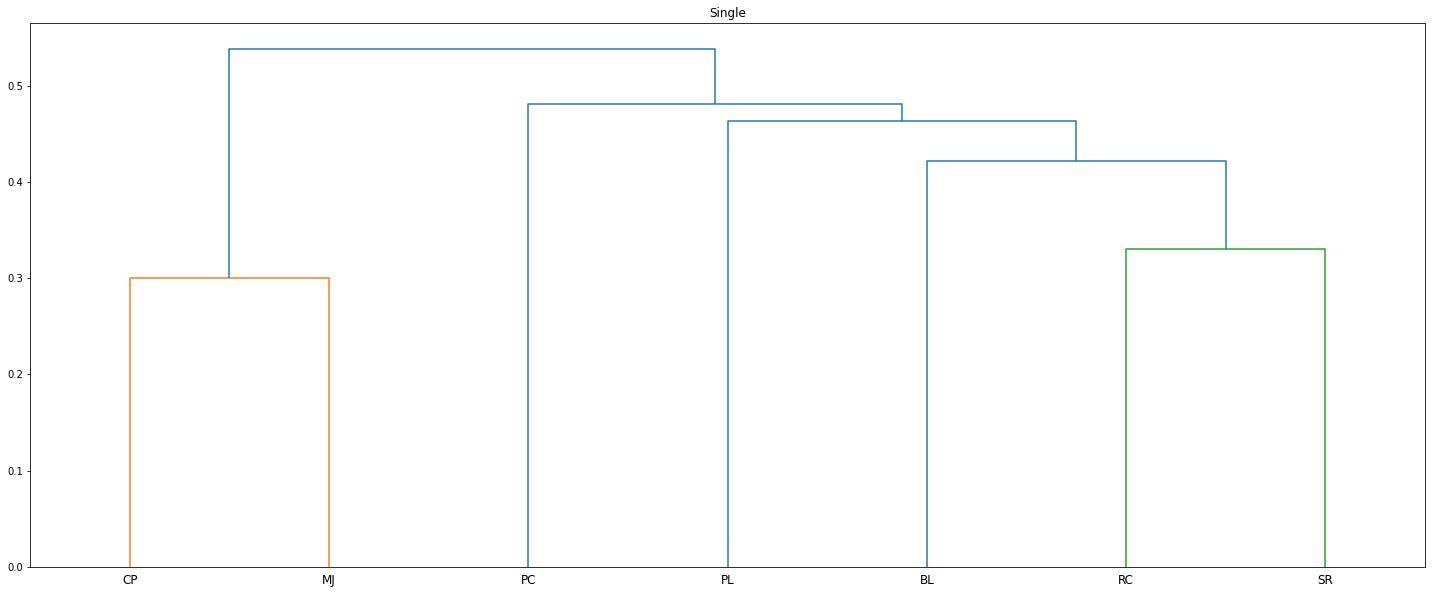

In [15]:
#| label: fig-7
#| fig-cap: "Dendrogram of Single Ward Method"
agg_mean = data.groupby('Region').agg('mean')
Z = linkage(agg_mean, 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=agg_mean.index)
plt.title('Single')
plt.show()

In fact, if we look at the next three dendrogram resulting from the average linkage, complete linkage, and ward linkage, we can see the similar pattern with only a slight difference. In these three methods, BL-RC-SR cluster are joined with the PC-PL cluster, rather than joined with PL and then PC like we have seen from the single linkage.

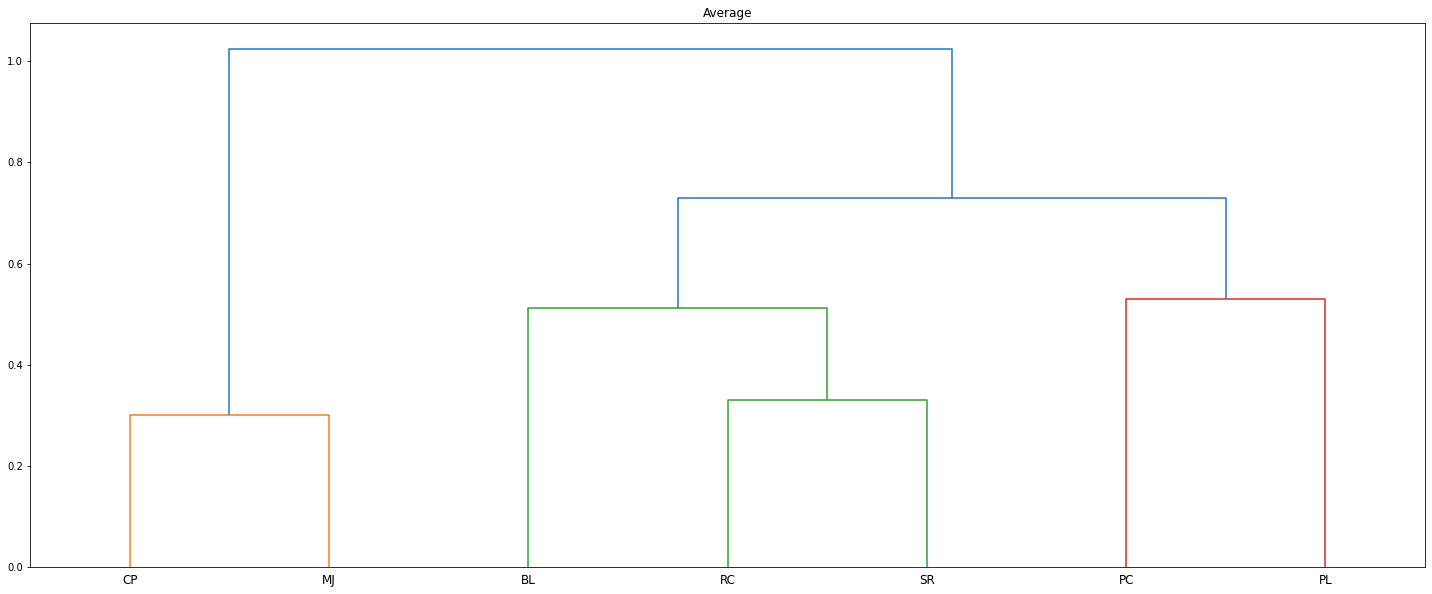

In [19]:
#| label: fig-8
#| fig-cap: "Dendrogram of Average Method"
Z = linkage(agg_mean, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=agg_mean.index)
plt.title('Average')
plt.show()

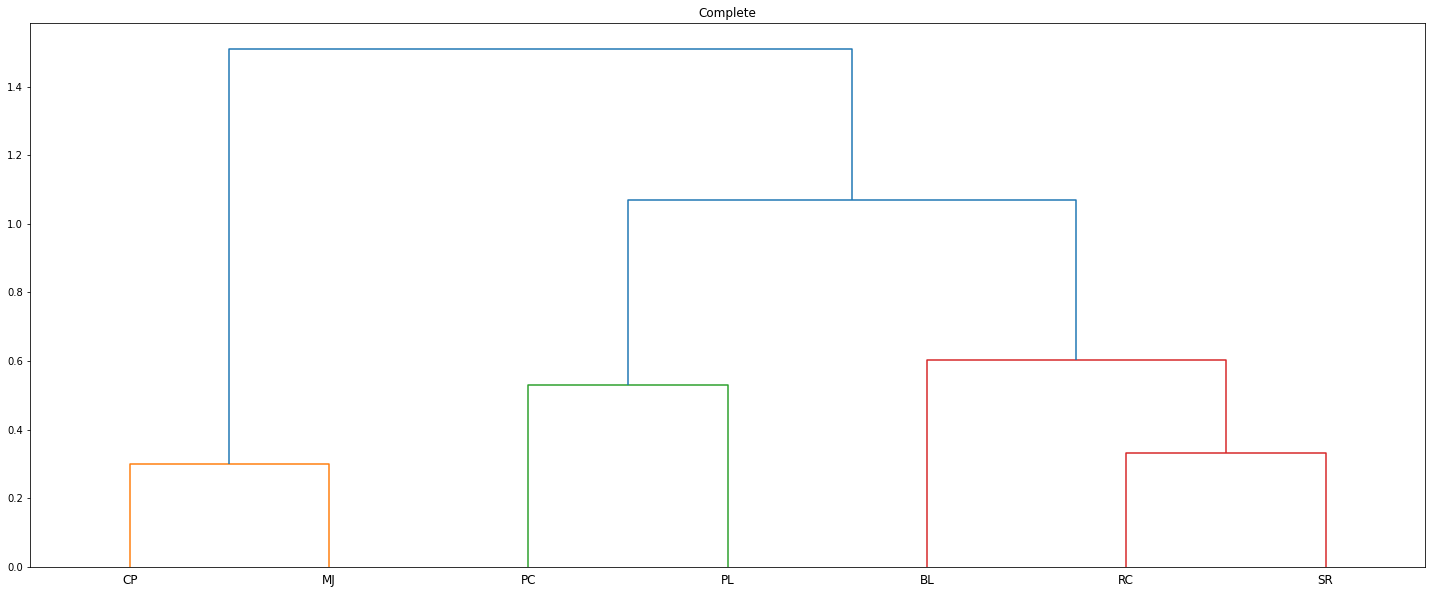

In [19]:
#| label: fig-9
#| fig-cap: "Dendrogram of Complete Method"
Z = linkage(agg_mean, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=agg_mean.index)
plt.title('Complete')
plt.show()

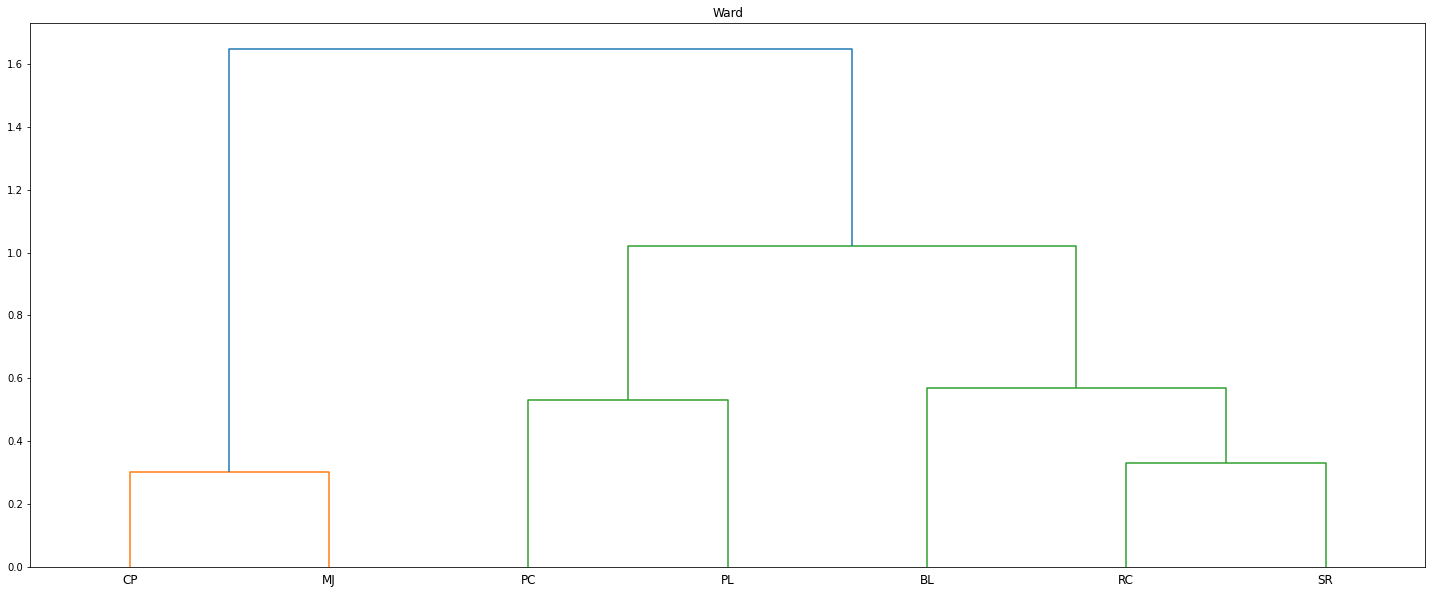

In [20]:
#| label: fig-10
#| fig-cap: "Dendrogram of Ward Method"
Z = linkage(agg_mean, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=agg_mean.index)
plt.title('Ward')
plt.show()

## Assign Cluster for Each Region

Here we create new column that indicates which cluster each well belongs to (according to the region).

In [20]:
cluster_raw_single = {"CP|MJ":1, "PC":2, "PL|BL|RC|SR":3}
data['Single'] = data['Region'].replace(cluster_raw_single, regex=True)

cluster_raw_avg = {"CP|MJ":1, "BL|RC|SR":2, "PC|PL":3}
data['Others'] = data['Region'].replace(cluster_raw_avg, regex=True)

# make it recognized as a category
data['Single'] = data['Single'].astype('object')
data['Others'] = data['Others'].astype('object')

In [22]:
#| label: tbl-6
#| tbl-cap: "Data After Cluster Assignment"
#| echo: false
data

,As,Cd,Co,Cr,Cu,Fe,Hg,Mn,Pb,Zn,Region,Single,Others
No,,,,,,,,,,,,,
1,0.0062,0.0001,0.0026,0.0069,0.0100,1.6585,0.0001,0.3428,0.0001,0.1079,MJ,1,1
2,0.0212,0.0006,0.0001,0.0070,0.0077,3.7910,0.0001,0.4119,0.0119,0.0309,MJ,1,1
3,0.0065,0.0001,0.0001,0.0062,0.0073,0.0820,0.0001,0.2206,0.0186,0.0521,MJ,1,1
4,0.0162,0.0006,0.0001,0.0084,0.0094,1.4833,0.0001,0.4985,0.0001,0.0886,MJ,1,1
5,0.0194,0.0001,0.0001,0.0086,0.0098,2.3356,0.0001,0.1716,0.0196,0.0641,MJ,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.0164,0.0001,0.0001,0.0059,0.0024,0.3552,0.0001,0.0012,0.0001,0.0739,SR,3,2
157,0.0196,0.0019,0.0171,0.0053,0.0125,0.1067,0.0001,0.7120,0.0495,0.8312,SR,3,2
158,0.0062,0.0001,0.0085,0.0076,0.0089,0.0684,0.0001,1.1956,0.0235,0.0755,SR,3,2


# Geographical Perspective

## Assign Longitude and Latitude


To support our consideration, let’s take a look at how these cluster represents the regions in geographical perspective.

It’s not hard to acquire longitude and latitude data for each region. I manually input them from Google Maps. For the plotting, I use [Plotly Express](https://plotly.com/python/plotly-express/).

In [21]:
replacer_long = {"MJ": 107.746994, "BL": 107.631878, "RC": 107.759404, "SR": 107.532008, "PL": 107.566423, "PC": 107.698135, "CP": 107.710501}
replacer_lat = {"MJ": -7.054680, "BL": -7.004517, "RC": -6.971517, "SR": -7.025404, "PL": -7.195907, "PC": -7.119608, "CP": -7.037803}
data['longitude'] = data['Region'].replace(replacer_long).astype(float)
data['latitude'] = data['Region'].replace(replacer_lat).astype(float)

## Final Data

In [22]:
#| label: tbl-7
#| tbl-cap: "Final Form of The Data"
#| echo: false
data

,As,Cd,Co,Cr,Cu,Fe,Hg,Mn,Pb,Zn,Region,Single,Others,longitude,latitude
No,,,,,,,,,,,,,,,
1,0.0062,0.0001,0.0026,0.0069,0.0100,1.6585,0.0001,0.3428,0.0001,0.1079,MJ,1,1,107.746994,-7.054680
2,0.0212,0.0006,0.0001,0.0070,0.0077,3.7910,0.0001,0.4119,0.0119,0.0309,MJ,1,1,107.746994,-7.054680
3,0.0065,0.0001,0.0001,0.0062,0.0073,0.0820,0.0001,0.2206,0.0186,0.0521,MJ,1,1,107.746994,-7.054680
4,0.0162,0.0006,0.0001,0.0084,0.0094,1.4833,0.0001,0.4985,0.0001,0.0886,MJ,1,1,107.746994,-7.054680
5,0.0194,0.0001,0.0001,0.0086,0.0098,2.3356,0.0001,0.1716,0.0196,0.0641,MJ,1,1,107.746994,-7.054680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.0164,0.0001,0.0001,0.0059,0.0024,0.3552,0.0001,0.0012,0.0001,0.0739,SR,3,2,107.532008,-7.025404
157,0.0196,0.0019,0.0171,0.0053,0.0125,0.1067,0.0001,0.7120,0.0495,0.8312,SR,3,2,107.532008,-7.025404
158,0.0062,0.0001,0.0085,0.0076,0.0089,0.0684,0.0001,1.1956,0.0235,0.0755,SR,3,2,107.532008,-7.025404


## Plot According to Geographical Data

Remember that we have two distinct results: one from single method, one from the other methods. Here is both results plotted on a map (*it's interactive*!).

In [24]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [25]:
#| label: fig-11
#| fig-cap: "Clustering Result Based on Single Method"
import plotly.express as px
import plotly.graph_objects as go

data_agg = data.groupby(['Region']).agg('mean')

fig = px.scatter_mapbox(data_agg, 
                        lat="latitude", 
                        lon="longitude", 
                        color="Single",
                        color_discrete_sequence=px.colors.qualitative.G10,
                        zoom=8,
                        height=500,
                        width=700,
                        text = list(data_agg.index))

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker={'size': 15})
fig.update_traces(textposition='top center')
fig.show()

In [26]:
#| label: fig-12
#| fig-cap: "Clustering Result Based on Others Method"

fig = px.scatter_mapbox(data_agg, 
                        lat="latitude", 
                        lon="longitude", 
                        color='Others',
                        color_discrete_sequence=px.colors.qualitative.G10,
                        hover_data={'index': (data_agg.index)},
                        zoom=8,
                        height=500,
                        width=700)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker={'size': 15})
fig.show()

Comparing these two results, I personally prefer the second one, where the regions are separated by latitude coordinate. It is intuitive and easy to interpret. However, we might need more data to make a clear conclusion, such as altitude and water distribution network.

## Clustering Summary

To summarize the preceding results, Ciparay (**CP**) and Majalengka (**MJ**) are always joined first resulting in **CP-MJ** cluster. In all four results, this **CP-MJ** cluster consistently joined last with a cluster containing the rest of the regions.

On the other side, Rancaekek (**RC**) and Soreang (**SR**) are always be the second points joined then resulting in **RC-SR** cluster. After that, this **RC-SR** cluster will always be joined with Baleendah (**BL**) resulting in **RC-SR-BL** cluster. In the single linkage result, the **RC-SR-BL** cluster is joined with Pangalengan (**PL**), resulting in **RC-SR-BL-PL** cluster, then joined with Pacet (**PC**), resulting in **RC-SR-BL-PL-PC** cluster. However, in other three results, **PC and PL** are joined first resulting in **PC-PL** cluster, then joined with the **RC-SR-BL** cluster, resulting **RC-SR-BL-PL-PC** cluster.

# Recommendation and Conclusion

## Recommendation

As we mentioned before, we will choose to divide regions into three clusters. There are two different clustering results that can be derived:

1. **CP-MJ** cluster, **SR-RC-BL-PL** cluster, **PC** cluster (single linkage)
2. **CP-MJ** cluster, **SR-RC-BL** cluster, **PC-PL** cluster (other linkages)
Based on our previous analysis, **I recommend the second clustering result**. Why? Firstly, because it is resulted from three different linkage methods, while the first clustering is resulted only from the single linkage method. Secondly, it is supported by geographical data: the second clustering has more intuitive and reasonable distinction based on each regions’ location; also it is more interpretable.

## Conclusion

In conclusion, the clustering analysis performed in this study has successfully achieved the first objective by grouping well water sources in Bandung into clusters with similar water quality profiles. With our results, we have gained valuable insights into the regional trends that define the well water structure in Bandung. These clusters also provide a clearer understanding of the geographical factors that influence water quality, allowing the government agencies and institutions to produce more precise targeting of treatment strategies.

Moving forward, this knowledge will also encourage society to promote public health and environmental awareness, especially in the quality of well water for the residents of Bandung.

## Reference

A.C Rencher. (2002). Methods of Multivariate Analysis 2nd Edition.